In [1]:
import numpy as np
import mne
import matplotlib
%matplotlib inline
#%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import scipy
import pickle
import networkx as nx
import igraph as ig
import pandas as pd
import preprocessing as prep
from epoch_connectivity import ConnEEG as cnegg
from epoch_connectivity import ConnectionMatrices as cm
from itertools import permutations

from epoch_connectivity.utils import FrequencyBand, only_EEG_channels

import mne_connectivity as mnecon

In [147]:
class Connectome(object):
    def __init__(self, ConnectionMatrix, channel_names, is_binary, thresholding_method=None, threshold=None):
        adjacency_matrix = ConnectionMatrix.copy()
        ch_names = channel_names
        self.is_binary = is_binary
        self.weight = 'length'
        
        if self.is_binary:
            self.weight = None
        
        #To create the network
        sinks, sources  = np.shape(adjacency_matrix)
        np.fill_diagonal(adjacency_matrix, 0) # no self-loops
        
        if thresholding_method is not None:

            if thresholding_method == "density":
                adjacency_flatten = adjacency_matrix.flatten()
                to_pick = int(threshold * (len(adjacency_flatten)) - len(adjacency_matrix))
                adjacency_flatten.sort()
                thresh = adjacency_flatten[-to_pick]
            elif thresholding_method == "absolut":
                thresh = threshold
                
            adjacency_matrix[adjacency_matrix >= thresh] = 1
            adjacency_matrix[adjacency_matrix < thresh] = 0
            
        relabel = {}
        for i in range(sinks):
            relabel[i] = ch_names[i]
                    
        network = nx.DiGraph(adjacency_matrix.T)
        network = nx.relabel_nodes(network, relabel, copy=True)
        for edge in network.edges:
            network[edge[0]][edge[1]]['length'] = 1 / network[edge[0]][edge[1]]['weight']
        
        self.network = network
    
    """def modularity(self):
        communities = [{'F3', 'Fp1', 'Fp2', 'F4'}, {'Fz', 'C3', 'Cz', 'C4', 'Pz'}, {'F7', 'T3', 'T5'},
                      {'F8', 'T4', 'T6'}, {'P3', 'O1', 'O2', 'P4'}]
        modularity = nx.algorithms.community.modularity(G=self.network, communities=communities, weight='lenght')
        return modularity"""

    def modularity(self):
        network_igraph = ig.Graph.from_networkx(self.network)
        membership = [1, 1, 1, 0, 0, 2, 3, 0, 0, 1, 4, 4, 4, 4, 1, 2, 3, 2, 3]
        return network_igraph.modularity(membership, weights=self.weight)
    
    def optimized_modularity(self):
        communities = nx.algorithms.community.greedy_modularity_communities(G=self.network, weight=self.weight, n_communities=5)
        modularity = nx.algorithms.community.modularity(G=self.network, communities=communities, weight=self.weight)
        return modularity
        
    def avg_betweenness_centrality(self):
        bc = np.array(list(nx.betweenness_centrality(G=self.network, normalized=True, weight=self.weight, endpoints=False).values()))
        return bc.mean()
    
    def global_efficiency_weighted(self):
        n = len(self.network)
        denom = n * (n - 1)
        if denom != 0:
            shortest_paths = dict(nx.all_pairs_dijkstra(self.network, weight = self.weight))
            g_eff = 0
            for u, v in permutations(self.network, 2):
                if u in shortest_paths.keys() and v in shortest_paths[u][0].keys():
                    g_eff += (1/shortest_paths[u][0][v])
        else:
            g_eff = 0
        return g_eff
    
    def degree_assortativity(self):
        return nx.degree_pearson_correlation_coefficient(G=self.network, weight=self.weight)
    
    def avg_clustering_coefficient(self):
        return nx.average_clustering(G=self.network, weight=self.weight)
    

class Connectomes(object):
    def __init__(self, PatientConnectionMatrices, measure, thresholding_method=None, threshold=None):
        self.CMs = PatientConnectionMatrices
        self.measure = measure
        self.adjacency_matrices = getattr(self.CMs, measure)
        nodes_names = only_EEG_channels(self.CMs.epoched_eeg.ch_names)
        self.is_binary = False
        
        if thresholding_method is not None:
            self.is_binary = True
        
        networks = {}
        for i in range(len(self.CMs.f_bands)):
            f_band = self.CMs.f_bands[i]
            networks[f_band] = Connectome(self.adjacency_matrices[i], nodes_names, thresholding_method=thresholding_method,
                                          threshold=threshold, is_binary=self.is_binary)
        
        self.networks = networks
            
    
    def modularity(self):
        modularity = {}
        for f_band in self.CMs.f_bands:
            modularity[f_band] = self.networks[f_band].modularity()
        return modularity
    
    def optimized_modularity(self):
        optimized_modularity = {}
        for f_band in self.CMs.f_bands:
            optimized_modularity[f_band] = self.networks[f_band].optimized_modularity()
        return optimized_modularity
        
    def avg_betweenness_centrality(self):
        avg_betweenness_centrality = {}
        for f_band in self.CMs.f_bands:
            avg_betweenness_centrality[f_band] = self.networks[f_band].avg_betweenness_centrality()
        return avg_betweenness_centrality
    
    def global_efficiency_weighted(self):
        g_eff = {}
        for f_band in self.CMs.f_bands:
            g_eff[f_band] = self.networks[f_band].global_efficiency_weighted()
        return g_eff
    
    def degree_assortativity(self):
        degree_assortativity = {}
        for f_band in self.CMs.f_bands:
            degree_assortativity[f_band] = self.networks[f_band].degree_assortativity()
        return degree_assortativity
    
    def avg_clustering_coefficient(self):
        avg_clustering_coefficient = {}
        for f_band in self.CMs.f_bands:
            avg_clustering_coefficient[f_band] = self.networks[f_band].avg_clustering_coefficient()
        return avg_clustering_coefficient
    
    def get_shortest_paths(self, data):
        
        lens_nets = {}
        lens_nets['path length'], lens_nets['freq. band'] = [], []
        
        for i in range(len(self.CMs.f_bands)):
            f_band = self.CMs.f_bands[i]
            current_net = self.networks[f_band].network
            shortest_paths = dict(nx.all_pairs_dijkstra(current_net, weight = data))
            
            for u, v in permutations(current_net, 2):
                if u in shortest_paths.keys() and v in shortest_paths[u][0].keys():
                    lens_nets['path length'].append(shortest_paths[u][0][v])
                    lens_nets['freq. band'].append(f_band)
        
        return lens_nets
    
    def _get_edges_quantile(self, central_percentile=False, percentiles_to_get=30, data='weight'):
        n_plot = len(self.CMs.f_bands)

        all_selected_edges, all_weights = [], []

        for i in range(n_plot):
            lengths = []
            f = self.CMs.f_bands[i]
            net_measure_frequency = self.networks[f].network
            list_of_edges = net_measure_frequency.edges(data=data)
            for u, v, a in list_of_edges:
                lengths.append(a)

            inv = 1 - percentiles_to_get/100
            selected, selected_weights = [], []
            if central_percentile:
                limits = np.quantile(lengths, [inv/2, 1-inv/2])
                for edge in list_of_edges:
                    if edge[2] >= limits[0] and edge[2] <= limits[1]:
                        selected.append((edge[0], edge[1]))
                        selected_weights.append(edge[2])
            else:
                if data=='weight':
                    limit = np.quantile(lengths, inv)
                elif data=='length':
                    limit = np.quantile(lengths, percentiles_to_get/100)
                for edge in list_of_edges:
                    if (edge[2] >= limit and data=='weight') or (edge[2] <= limit and data=='length'):
                        selected.append((edge[0], edge[1]))
                        selected_weights.append(edge[2])
            all_selected_edges.append(selected)
            all_weights.append(selected_weights)
        
        max_weight, min_weight = all_weights[0][0], all_weights[0][0]
        for line in all_weights:
            for weight in line:
                if weight > max_weight:
                    max_weight = weight
                if weight < min_weight:
                    min_weight = weight
        
        return all_selected_edges, all_weights, max_weight, min_weight
    
    def boxplot_path_length(self, data):
        paths = pd.DataFrame(Cntome.get_shortest_paths(data=data))
        sns.boxplot(x='freq. band', y='path length', data=paths)
        plt.title('Shortest paths length distribution for patient '+ str(self.CMs.patient) + " " + self.CMs.rec_status + " " + self.measure)
        
    
    def plot_histogram(self, data='length', savefigure=False, fformat='.pdf', directory=None, bins=12):
        n_plot = len(self.CMs.f_bands)
        v, h = 3, int(np.ceil(n_plot/3))
        axes = []
        fig = plt.figure(figsize=[h*6.4, v*4.8])
        
        for i in range(n_plot):
            axes.append(fig.add_subplot(v*100+h*10+i+1))
            f = self.CMs.f_bands[i]
            net_measure_frequency = self.networks[f].network
            lengths = []
            for _, _, a in net_measure_frequency.edges(data=data):
                lengths.append(a)
            sns.histplot(lengths, bins=bins, ax=axes[i])
            axes[i].set_title(f)
        fig.suptitle(self.measure + ' on patient ' + str(self.CMs.patient) + ' while ' + self.CMs.rec_status, fontsize=16, y=0.94)
        
    def plot_measure(self, percentiles_to_get=30, central_percentile=False, savefigure=False, fformat='.pdf', directory=None, data='weight'):
        
        pos = {'Fp1': (921.875, 375.04643999999996), 'Fp2': (1359.375, 375.04643999999996), 'F7': (593.75, 625.0774),
               'F8': (1687.5, 625.0774), 'F3': (875.0, 671.958205), 'Fz': (1156.25, 671.958205), 'F4': (1421.875, 671.958205),
               'T3': (468.75, 1015.750775), 'C3': (812.5, 1015.750775), 'Cz': (1156.25, 1015.750775), 'C4': (1484.375, 1015.750775),
               'T4': (1828.125, 1015.750775), 'T5': (593.75, 1406.42415), 'T6': (1687.5, 1406.42415), 'P3': (875.0, 1359.543345),
               'Pz': (1156.25, 1359.543345), 'P4': (1421.875, 1359.543345), 'O1': (921.875, 1656.4551099999999),
               'O2': (1359.375, 1656.4551099999999)}
        img = plt.imread("epoch_connectivity/10-20-mod.png")
        
        n_plot = len(self.CMs.f_bands)
        v, h = 3, int(np.ceil(n_plot/3))
        fig = plt.figure(figsize=[h*6.4, v*4.8])
        
        axes = []
        for i in range(n_plot):
            axes.append(fig.add_subplot(v*100+h*10+i+1)) 
            
        all_edges, all_weights, max_weight, min_weight = self._get_edges_quantile(central_percentile=central_percentile,
                                                                                  percentiles_to_get=percentiles_to_get,
                                                                                  data=data)

        plt.subplots_adjust(top=0.90)
        for i in range(n_plot):
            f = self.CMs.f_bands[i]
            net_measure_frequency = self.networks[f].network
            axes[i].imshow(img)
            
            nx.draw_networkx_nodes(net_measure_frequency, pos, node_color='black',
                                   node_size = 10, ax=axes[i], alpha=1)
            #nx.draw_networkx_labels(net_measure_frequency, pos, ax=axes[i])

            weights = all_weights[i].copy()
            edges = all_edges[i].copy()
            
            cmap = plt.cm.viridis

            nx.draw_networkx_edges(net_measure_frequency, pos, edgelist=edges, edge_color=weights,
                    width=2, edge_cmap=cmap, ax=axes[i], edge_vmax=max_weight, edge_vmin=min_weight, node_size=10)
            
            if not self.is_binary:                        
                norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
                fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[i], orientation='vertical')
    
            axes[i].set_title(f)
        fig.suptitle(self.measure + ' on patient ' + str(self.CMs.patient) + ' while ' + self.CMs.rec_status, fontsize=16, y=0.94)
        if savefigure:
            save_file_name = 'connectome_PAT' + str(self.CMs.patient) + '_' + self.CMs.rec_status + '_' + self.measure + fformat
            plt.savefig(directory+save_file_name)

In [148]:
direc_pickle = 'C:/code_thesis/brain_connectivity_epilepsy/cm_test/'
pat_num = 2
patient_code = 'PAT'+str(pat_num)
MyCM = pickle.load(open(direc_pickle+patient_code+'_'+'AWAKE.pickle', 'rb'))

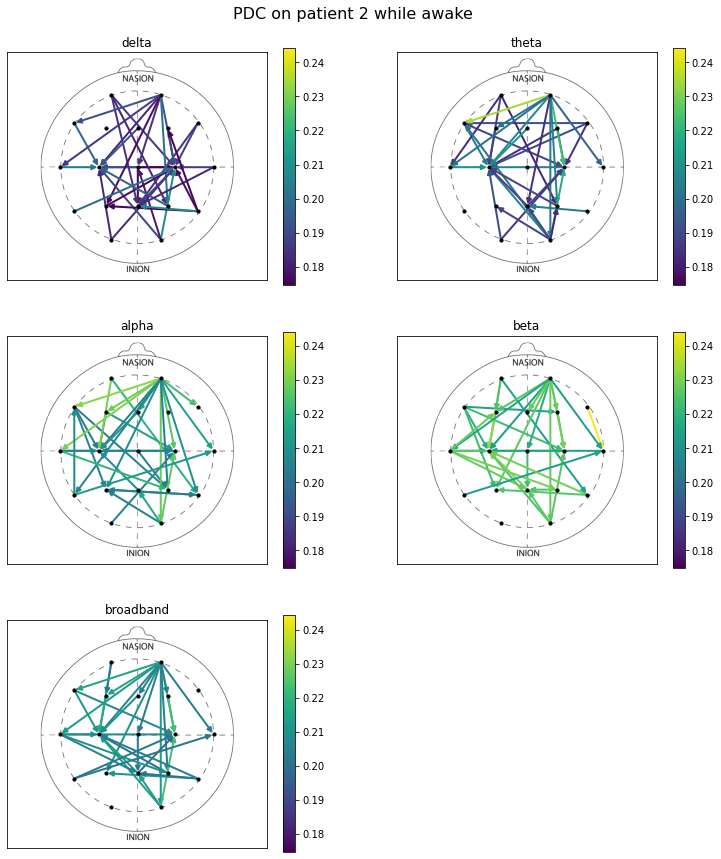

In [151]:
Cntome = Connectomes(MyCM, 'PDC')#,  thresholding_method='density', threshold=0.6)
directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
Cntome.plot_measure(percentiles_to_get=10, central_percentile=False, data='weight')

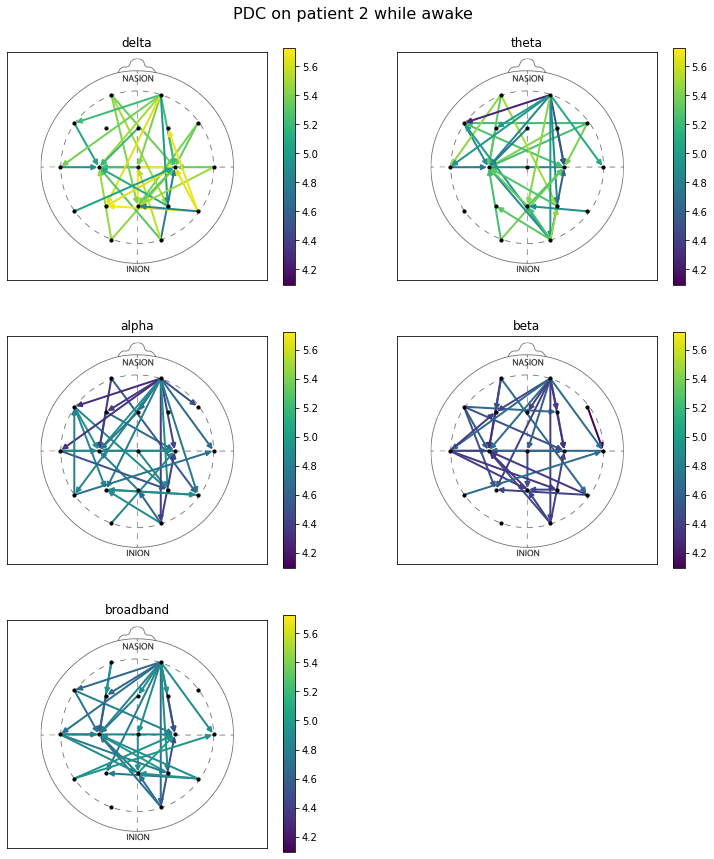

In [149]:
Cntome = Connectomes(MyCM, 'PDC')#,  thresholding_method='density', threshold=0.6)
directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
Cntome.plot_measure(percentiles_to_get=10, central_percentile=False, data='length')

In [127]:
asdf, weights, max_weight, min_weight = Cntome._get_edges_quantile()
for line in asdf:
    print(len(line)/(19*18))

0.2953216374269006
0.2982456140350877
0.2982456140350877
0.30116959064327486
0.30116959064327486


In [128]:
print(max_weight, min_weight)

1314.239140738999 18.323349295077147


In [122]:
min_w

1314.239140738999 18.323349295077147


In [85]:
graph = Cntome.networks['delta'].network
graph.edges(data='weight')

OutEdgeDataView([('C3', 'C4', 0.021731301752643314), ('C3', 'Cz', 0.0030507117107761855), ('C3', 'F3', 0.039943692710381715), ('C3', 'F4', 0.018567933163312525), ('C3', 'F7', 0.0015427153482239562), ('C3', 'F8', 0.03750917721187978), ('C3', 'Fp1', 0.014167933028671158), ('C3', 'Fp2', 0.04411568543696941), ('C3', 'Fz', 0.06398085180449863), ('C3', 'O1', 0.03261082756576173), ('C3', 'O2', 0.04300354977531644), ('C3', 'P3', 0.018616837912138435), ('C3', 'P4', 0.05764395982362464), ('C3', 'Pz', 0.027763790913035134), ('C3', 'T3', 0.001759272229074389), ('C3', 'T5', 0.03761680000948236), ('C3', 'T6', 0.0313963075187821), ('C4', 'C3', 0.15783670101055491), ('C4', 'Cz', 0.05333257825477811), ('C4', 'F3', 0.06693811573762257), ('C4', 'F4', 0.1903608505579402), ('C4', 'F7', 0.11637990997508658), ('C4', 'F8', 0.1203959252950723), ('C4', 'Fp1', 0.022976995076267093), ('C4', 'Fp2', 0.07819524967769734), ('C4', 'Fz', 0.0528662232634368), ('C4', 'O1', 0.10247981551493783), ('C4', 'O2', 0.09924584984

In [82]:
def _get_edges_quantile(self, central_percentile=False, percentiles_to_get=30):
    n_plot = len(self.CMs.f_bands)
    
    all_selected_edges = []
    
    for i in range(n_plot):
        lengths = []
        f = self.CMs.f_bands[i]
        net_measure_frequency = self.networks[f].network
        list_of_edges = net_measure_frequency.edges(data='length')
        for u, v, a in list_of_edges:
            lengths.append(a)
        
        for edge in list_of_edges:
            if 
            
        inv = 1 - percentiles_to_get/100
        selected = []
        if central_percentile:
            limits = np.quantile(lengths, [inv/2, 1-inv/2])
            for edge in list_of_edges:
                if edge[2] >= limits[0] and edge[2] <= limits[1]:
                    selected.append(edge)
        else:
            limit = np.quantile(lengths, inv)
            for edge in list_of_edges:
                if edge[2] >= limit:
                    selected.append(edge)
        all_selected_edges.append(selected)
    return all_selected
        
            
            


    quant_pegar = 0.25
    inv = 1 - quant_pegar
    lista = [inv/2, 1-inv/2]

    limits = np.quantile(lengths, lista)

    cnt = 0
    for weight in lengths:
        if weight >= limits[0] and weight <= limits[1]:
            cnt += 1
    print(cnt/len(lengths))
    print(limits)

{'delta': 0.024767801857585137,
 'theta': 0.02132782937736498,
 'alpha': 0.021671826625386997,
 'beta': 0.020123839009287926,
 'broadband': 0.016683866529067767}

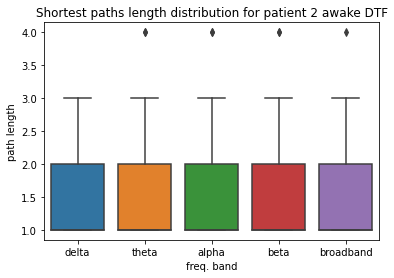

In [51]:
Cntome = Connectomes(MyCM, 'DTF',  thresholding_method='density', threshold=0.3)
#directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
#Cntome.plot_measure(savefigure=False, fformat='.pdf', directory=directoryr, n_strongest_connections=30)



# Plot box-PLOT for average path length
Cntome.boxplot_path_length(data=None)

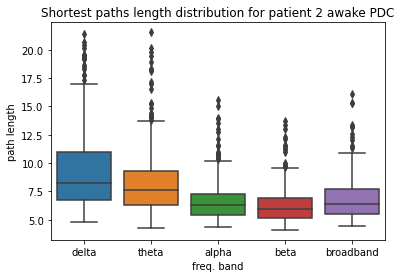

In [17]:
Cntome = Connectomes(MyCM, 'PDC')#,  thresholding_method='density', threshold=0.3)
#directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
#Cntome.plot_measure(savefigure=False, fformat='.pdf', directory=directoryr, n_strongest_connections=30)



# Plot box-PLOT for average path length
Cntome.boxplot_path_length(data='length')

<AxesSubplot:xlabel='freq. band', ylabel='path length'>

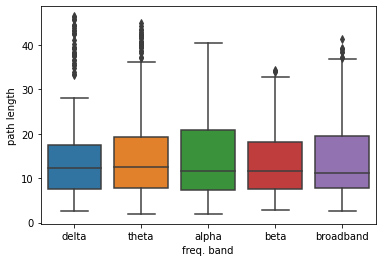

In [138]:
Cntome = Connectomes(MyCM, 'DTF')#,  thresholding_method='density', threshold=0.3)
#directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
#Cntome.plot_measure(savefigure=False, fformat='.pdf', directory=directoryr, n_strongest_connections=30)



# Plot box-PLOT for average path length
boxplot_path_lenght(self, data=)

In [96]:
grph = Cntome.networks['delta'].network

'''lengths = []
for u, v, a in grph.edges(data='length'):
    lengths.append(a)


quant_pegar = 0.25
inv = 1 - quant_pegar
lista = [inv/2, 1-inv/2]

limits = np.quantile(lengths, lista)

cnt = 0
for weight in lengths:
    if weight >= limits[0] and weight <= limits[1]:
        cnt += 1
print(cnt/len(lengths))
print(limits)'''

shortest_paths = dict(nx.all_pairs_dijkstra(grph, weight = 'length'))
shortest_paths

lens = []
for u, v in permutations(grph, 2):
                if u in shortest_paths.keys() and v in shortest_paths[u][0].keys():
                    lens.append(shortest_paths[u][0][v])

In [103]:
np.quantile(lens, [0.01, 0.99])

array([ 3.09322244, 45.05550071])

<AxesSubplot:>

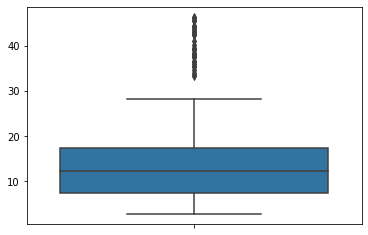

In [114]:
sns.boxplot(y=lens)

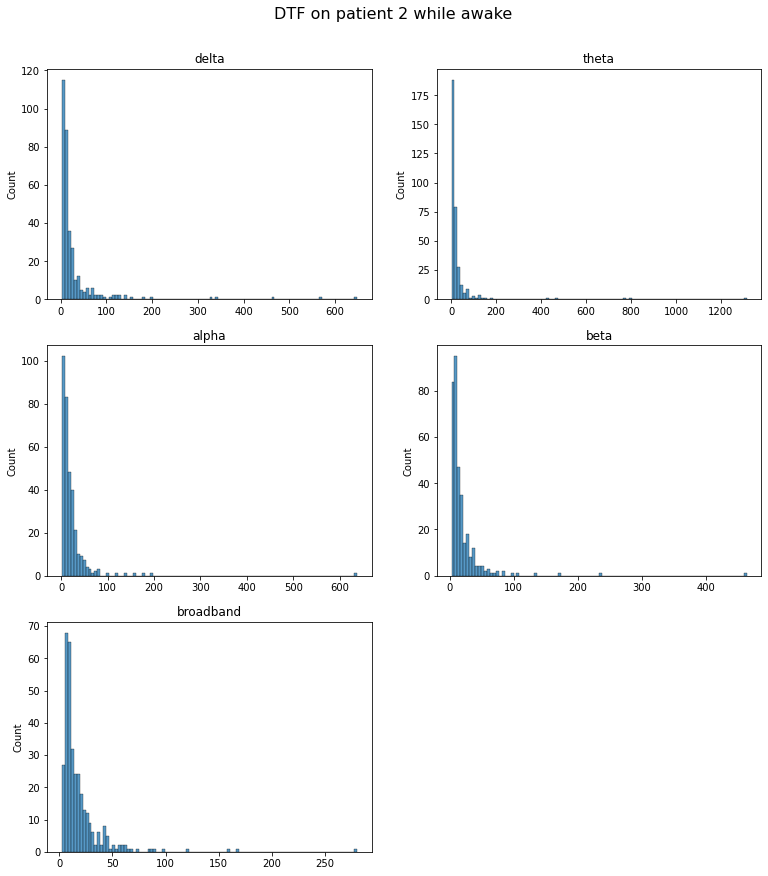

In [80]:
Cntome.plot_histogram(bins=100, data='length')

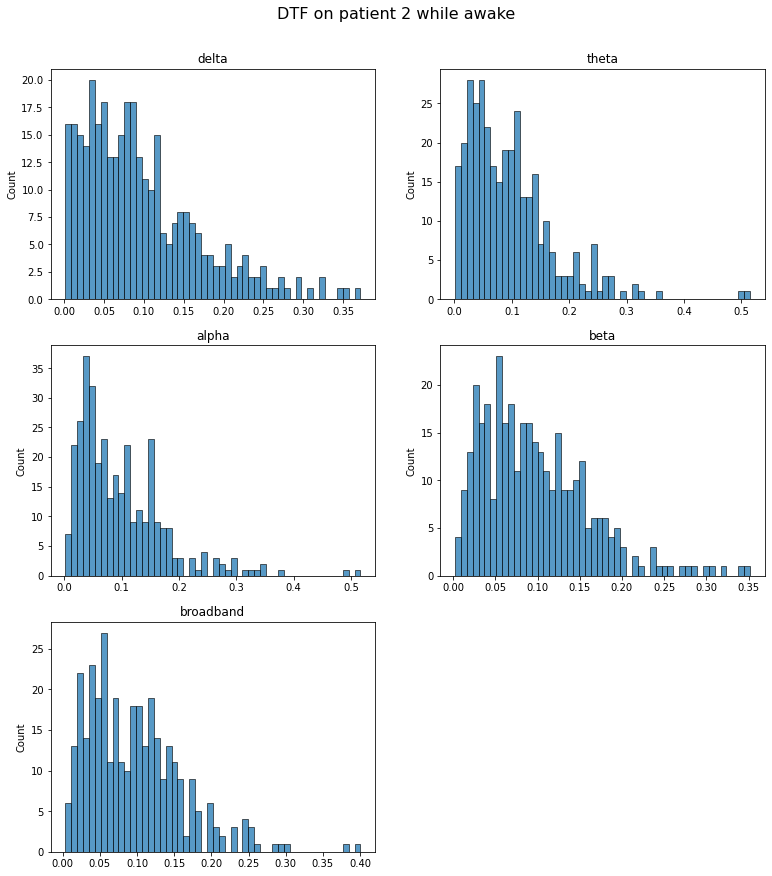

In [75]:
Cntome.plot_histogram(bins=50, data='weight')

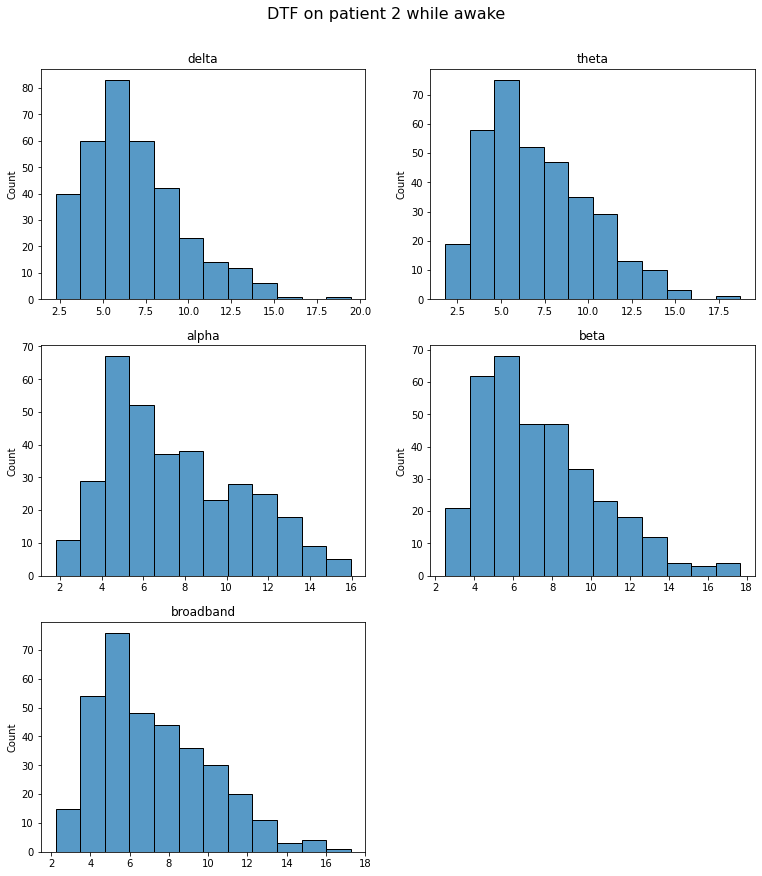

In [63]:
Cntome.plot_histogram()

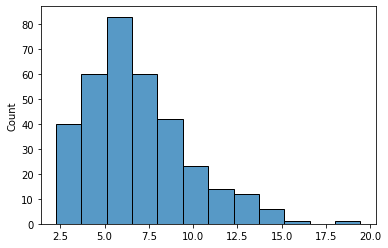

In [33]:
def plot_degree_dist(G):
    degrees = [G.degree(n, weight='length') for n in G.nodes()]
    plt.hist(degrees)
    plt.show()
    
grph = Cntome.networks['delta'].network

lengths = []
for u, v, a in grph.edges(data='length'):
    lengths.append(a)
sns.histplot(lengths, bins=12)
plt.show()

In [43]:
quant_pegar = 0.25
inv = 1 - quant_pegar
lista = [inv/2, 1-inv/2]

limits = np.quantile(lengths, lista)

cnt = 0
for weight in lengths:
    if weight >= limits[0] and weight <= limits[1]:
        cnt += 1
print(cnt/len(lengths))

0.25146198830409355


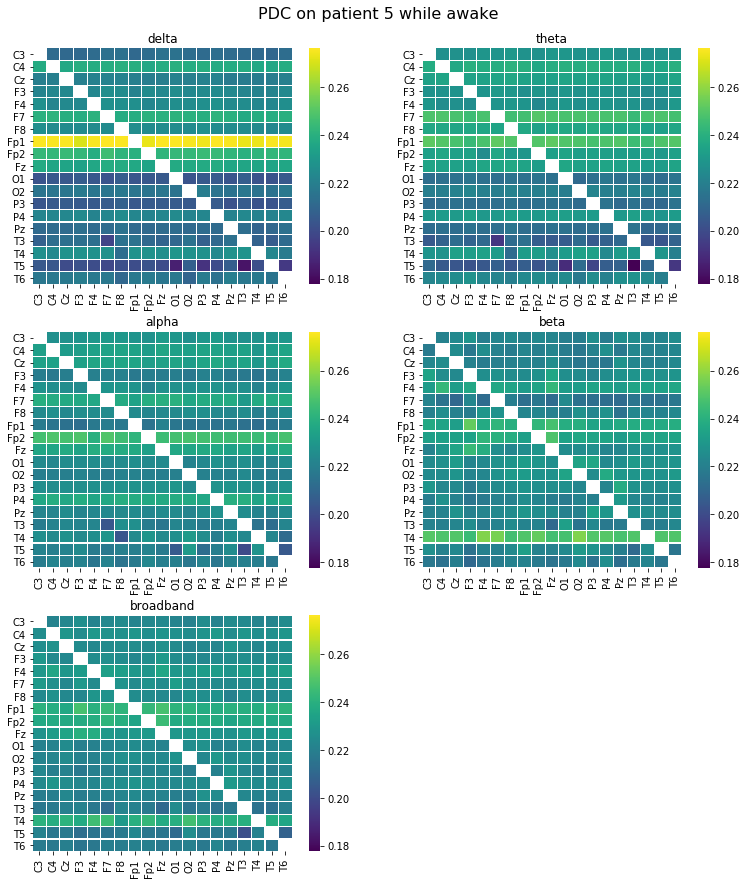

In [56]:
MyCM.plot_fbands_hmaps(measure='PDC', savefigure=False, hide_diag=True)